In [ ]:
# from typing import List, Dict, Tuple, Optional, Callable, Any
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim

from src.algorithms.adam import AdamOptimizer
from src.algorithms.optimize import (
    optimize_with_multiple_optimizers,
    optimize_with_one_optimizer,
    optimize_workflow,
    tune_parameters,
    tune_parameters_multiple
)
from src.algorithms.optim_utils import (
    plot_convergence_path,
    plot_multiple_convergence_paths
)
from src.algorithms.test_functions import (
    ackley,
    ackley_grad,
    mk_gauss,
    mk_quad,
    rosenbrock,
    rosenbrock_grad,

)


ModuleNotFoundError: No module named 'src'

/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


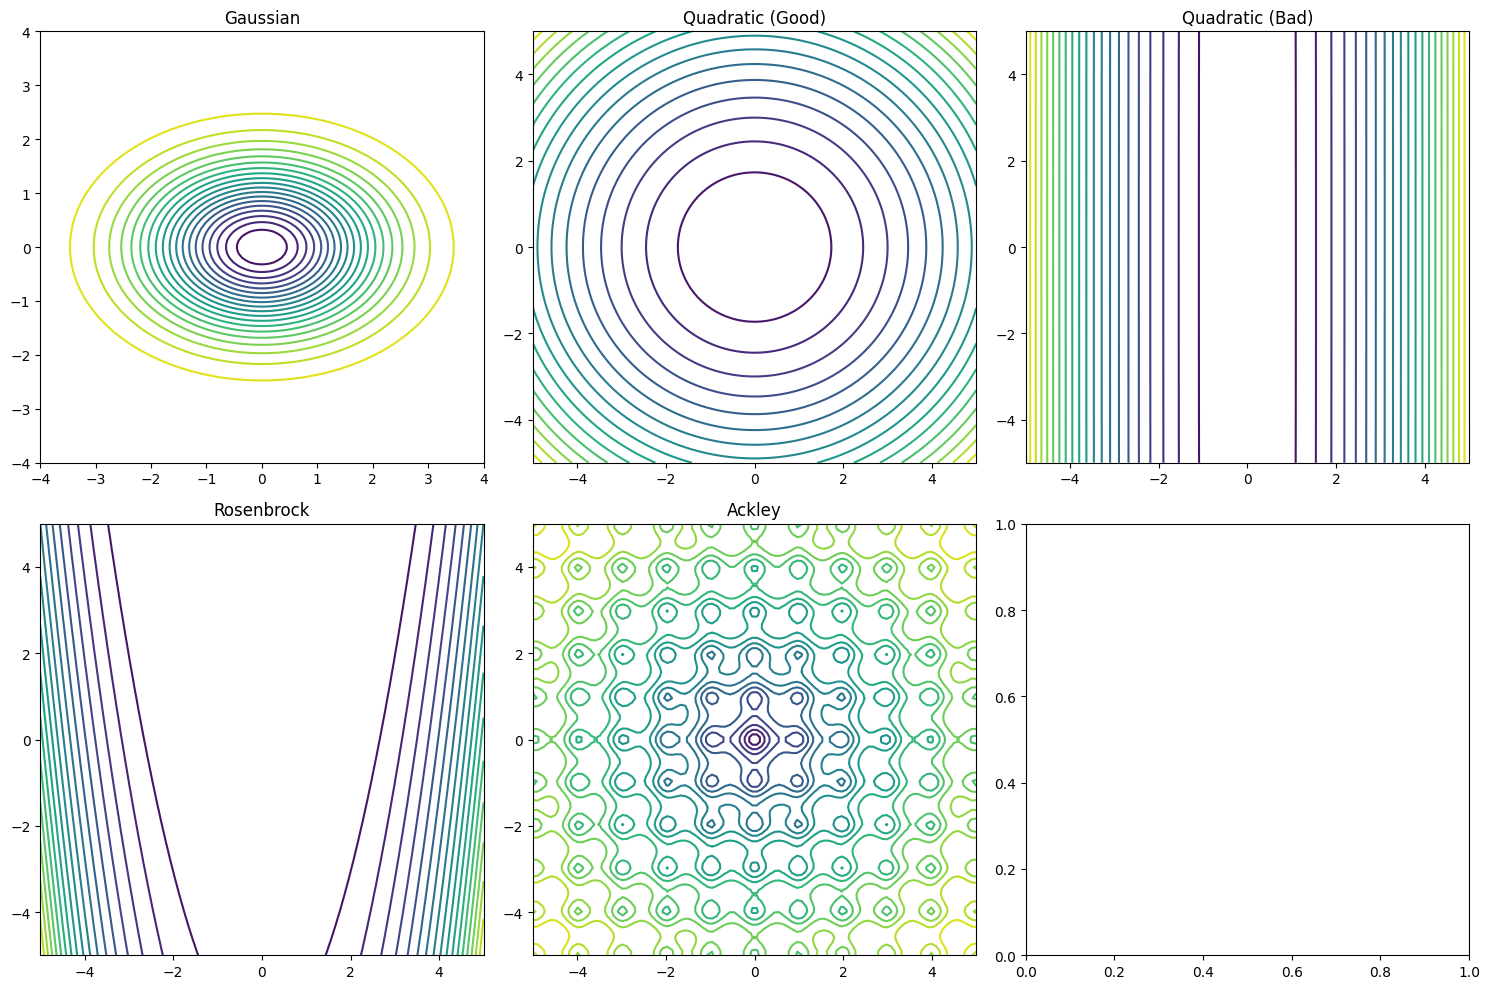

In [ ]:
# Test Functions
quadratic_good, quadratic_good_grad = mk_quad(1)
quadratic_bad, quadratic_bad_grad = mk_quad(0.02)
gauss, gauss_grad = mk_gauss(1.4)

# Function with a grid range of -4 to 4
gauss_range = 4
x_gauss = torch.linspace(-gauss_range, gauss_range, 100)
y_gauss = torch.linspace(-gauss_range, gauss_range, 100)
X_gauss, Y_gauss = torch.meshgrid(x_gauss, y_gauss)

# List of functions and their names
functions = [gauss, quadratic_good, quadratic_bad, rosenbrock, ackley]
function_names = ['Gaussian', 'Quadratic (Good)', 'Quadratic (Bad)', 'Rosenbrock', 'Ackley', 'Sphere']

# Create a 3x2 subplot grid
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plot contours for each function
for ax, function, name in zip(axes.flatten(), functions, function_names):
    if function == gauss:
        X, Y = X_gauss, Y_gauss
    else:
        x = torch.linspace(-5, 5, 100)
        y = torch.linspace(-5, 5, 100)
        X, Y = torch.meshgrid(x, y)

    # Initialize Z with zeros
    Z = torch.zeros_like(X)

    # Evaluate the function at each point on the grid using itertools.product
    for i, j in product(range(X.shape[0]), range(X.shape[1])):
        point = torch.tensor([X[i, j].item(), Y[i, j].item()])
        Z[i, j] = function(point)

    # Convert to NumPy arrays for contour plot
    X = X.detach().numpy()
    Y = Y.detach().numpy()
    Z = Z.detach().numpy()

    ax.contour(X, Y, Z, levels=20, cmap='viridis')
    ax.set_title(name)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

## Adam Optimizer

In [ ]:
# Set a manual seed for reproducibility
torch.manual_seed(0)

# Generate an initial random guess
initial_guess = torch.rand(2)

# Create a quadratic objective function and its gradient
objective_function, gradient_function = mk_quad(0.98, ndim=2)

# Initialize the Adam optimizer with a learning rate of 0.1
adam_optimizer = AdamOptimizer(0.1)

# Use Adam optimizer to minimize the objective function
optimized_theta, min_value, min_gradient = adam_optimizer.minimize(
    initial_guess, objective_function, gradient_function
)

# Print the results
print("Initial Guess:", initial_guess)
print("\nOptimized Theta:", optimized_theta)
print("\nMinimum Value:", min_value)
print("\nGradient at Minimum:", min_gradient)
print("\nAll x_k:", adam_optimizer.all_x_k[:2])
print("\nAll f_k:", adam_optimizer.all_f_k[:2])

Initial Guess: tensor([0.4963, 0.7682])

Optimized Theta: tensor([1.5886e-07, 4.3826e-07])

Minimum Value: tensor(1.0485e-13)

Gradient at Minimum: tensor([1.5886e-07, 4.2090e-07])

All x_k: [array([0.4962566, 0.7682218], dtype=float32), array([0.3962573, 0.6682225], dtype=float32)]

All f_k: [array(0.4065324, dtype=float32), array(0.29292947, dtype=float32)]


## BGE

In [ ]:
import torch
import math
from collections import defaultdict

class GradientPredictionModel:
    def __init__(self, alpha):
        self.alpha = alpha
        self.prev_grad = None

    def predict(self, grad):
        if self.prev_grad is None or self.prev_grad.size() != grad.size():
            self.prev_grad = torch.zeros_like(grad)
        predicted_grad = self.alpha * self.prev_grad + (1 - self.alpha) * grad
        self.prev_grad = predicted_grad.detach()
        return predicted_grad

def compute_gradient_change_rate(grad, prev_grad):
    if prev_grad is None or prev_grad.size() != grad.size():
        return 0
    change_rate = torch.norm(grad - prev_grad) / (torch.norm(prev_grad) + 1e-8)
    return change_rate.item()

def compute_dynamic_beta(change_rate, min_val, max_val):
    beta = min_val + (max_val - min_val) * (1 - change_rate)
    return min(max(beta, min_val), max_val)

class BGE_Adam():
    def __init__(self, params, lr=0.001, alpha=0.5, betas=(0.9, 0.999), eps=1e-8, weight_decay=0,
                 entropy_weight=0.01, amsgrad=False, beta1_max=0.9, beta1_min=0.5, beta2_max=0.999,
                 beta2_min=0.9):
        self.defaults = dict(lr=lr, alpha=alpha, betas=betas, eps=eps, weight_decay=weight_decay,
                        entropy_weight=entropy_weight, amsgrad=amsgrad,
                        beta1_max=beta1_max, beta1_min=beta1_min,
                        beta2_max=beta2_max, beta2_min=beta2_min)
        self.gradient_prediction_model = {}
        self.state = defaultdict(dict)
        self.param_groups = []

        param_groups = list(params)
        if not isinstance(param_groups[0], dict):
            param_groups = [{'params': param_groups}]
        for param_group in param_groups:
            param_group['params'] = list(param_group['params'])
            for name, default in self.defaults.items():
                param_group.setdefault(name, default)
            self.param_groups.append(param_group)

    def zero_grad(self, set_to_none: bool = False):
            for group in self.param_groups:
                for p in group['params']:
                    if p.grad is not None:
                        if set_to_none:
                            p.grad = None
                        else:
                            if p.grad.grad_fn is not None:
                                p.grad.detach_()
                            else:
                                p.grad.requires_grad_(False)
                            p.grad.zero_()

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data

                amsgrad = group['amsgrad']
                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsgrad:
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad.add_(p.data, alpha=group['weight_decay'])

                # Compute beta1 and beta2 values dynamically based on gradient change rate
                prev_grad = state['exp_avg'] if 'exp_avg' in state else None
                gradient_change_rate = compute_gradient_change_rate(grad, prev_grad)
                beta1 = compute_dynamic_beta(gradient_change_rate, group['beta1_min'], group['beta1_max'])
                beta2 = compute_dynamic_beta(gradient_change_rate, group['beta2_min'], group['beta2_max'])

                # Update the moving averages of gradient and its square
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                if amsgrad:
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                # Prediction of next gradient (gradient_prediction_model)
                if p in self.gradient_prediction_model:
                    predicted_grad = self.gradient_prediction_model[p].predict(grad)
                else:
                    self.gradient_prediction_model[p] = GradientPredictionModel(group['alpha'])
                    predicted_grad = self.gradient_prediction_model[p].predict(grad)

                # Final parameter update with entropy adjustment
                entropy_adjustment = 1 + group['entropy_weight'] * torch.randn_like(p.data).mean()
                p.data.addcdiv_(predicted_grad, denom, value=-step_size * entropy_adjustment)

        return loss


## Wrapper for Optimizers

In [ ]:
# Set a seed for reproducibility
np.random.seed(42)

# Define the initial guess
x_init = np.random.rand(2)
print("Initial guess:", x_init.round(3))

# Optimize using SGD
optim_kwargs_sgd={
    "lr": 1e-4,
    "nesterov": True,
    "momentum": 0.99,
    "dampening": 0.
}
solutions_sgd, images_sgd = optimize_with_one_optimizer(
    optimizer_cls=optim.SGD,
    x_init=x_init,
    loss_fn=rosenbrock,
    optim_kwargs=optim_kwargs_sgd,
    max_iter=1000
)
print("\n======= OPTIM SGD-N FROM (PYTORCH) =======")
print("Final Solution:", solutions_sgd[-1].round(3),
      len(solutions_sgd)-1, "iterations")
print("Final Value:", images_sgd[-1].round(3))

# Optimize using Adam
solutions_adam, images_adam = optimize_with_one_optimizer(
    optimizer_cls=AdamOptimizer,
    x_init=x_init,
    loss_fn=rosenbrock,
    loss_grad=rosenbrock_grad,
    optim_kwargs={"lr": 1e-1},
    max_iter=1000
)
print("\n====== OPTIM ADAM FROM (LOCAL) ===========")
print("Final Solution:", solutions_adam[-1].round(3),
      len(solutions_adam)-1, "iterations")
print("Final Value:", images_adam[-1].round(3))

Initial guess: [0.375 0.951]

======= OPTIM SGD-N FROM (PYTORCH) =======
Final Solution: [1.009 1.018] 1000 iterations
Final Value: 0.0

====== OPTIM ADAM FROM (LOCAL) ===========
Final Solution: [0.991 0.981] 1000 iterations
Final Value: 0.0


In [ ]:
def run_optimizers(x_init, loss_fn, loss_grad, optimizers_config, max_iter=1000, tol_grad=1e-6):
    # Optimize with multiple optimizers
    solutions, values = optimize_with_multiple_optimizers(
        x_init=x_init,
        loss_fn=loss_fn,
        loss_grad=loss_grad,
        optimizers_config=optimizers_config,
        max_iter=max_iter,
        tol_grad=tol_grad
    )

    # Display the results for each optimizer
    for optimizer, solution in solutions.items():
        print(f"{optimizer} - Final Solution: {list(solution[-1].round(5))} || "
              f"Final Value: {values[optimizer][-1].round(2)}")

    return solutions, values

# Define the optimizers and their configurations
optimizers_config = {
    "Adagrad": (optim.Adagrad, {"lr": 1e-1, "lr_decay": 0.1}),
    "RMSprop": (optim.RMSprop, {"lr": 1e-2, "alpha": 0.8}),
    "SGD-Nesterov": (optim.SGD, {
        "lr": 1e-3, "nesterov": True, "momentum": 0.9, "dampening": 0}),
    "Adam": (AdamOptimizer, {"lr": 1e-1, "beta1": 0.9, "beta2": 0.999}),
    "BGE_Adam": (BGE_Adam, {"lr":0.1}),
}

# Run the optimization with defined parameters
solutions, values = run_optimizers(x_init, quadratic_good, quadratic_good_grad, optimizers_config)

Adagrad - Final Solution: [0.00021, 0.25269] || Final Value: 0.03
RMSprop - Final Solution: [-0.0, 0.37716] || Final Value: 0.07
SGD-Nesterov - Final Solution: [1e-05, 2e-05] || Final Value: 0.0
Adam - Final Solution: [-0.0, 0.0] || Final Value: 0.0
BGE_Adam - Final Solution: [-1e-05, 0.00012] || Final Value: 0.0


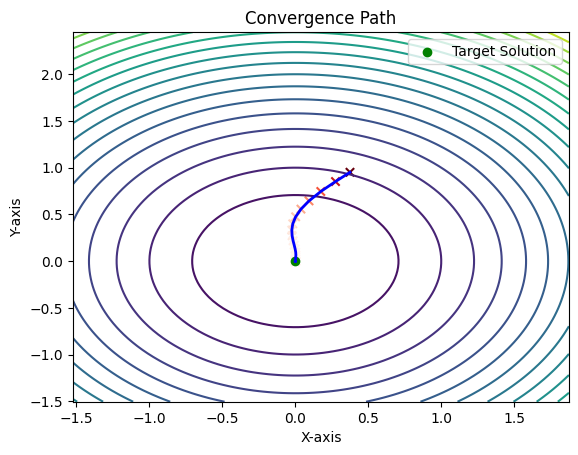

In [ ]:
# Extract solutions sequence for the "BGE adam" (local implementation) optimizer
solutions_sequence = solutions["BGE_Adam"]

# Define the target solution for comparison
target_solution = torch.tensor([0, 0], dtype=torch.float32)

# Plot the convergence path
plot_convergence_path(solutions_sequence, quadratic_good, target_solution)

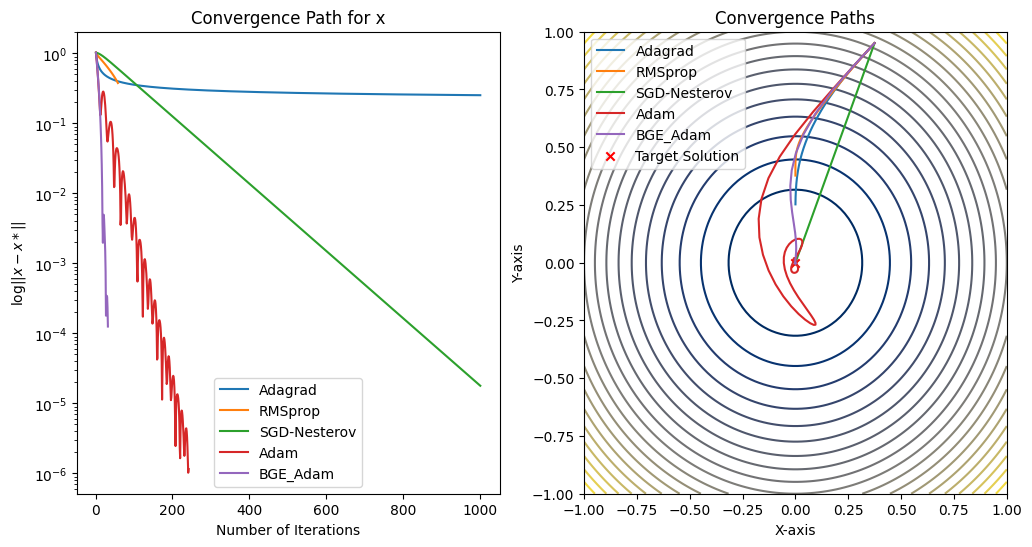

In [ ]:
# Define the target solution for comparison
solutions_dict = solutions
target_solution = torch.tensor([0, 0], dtype=torch.float32)

# Plot convergence paths for different algorithms within a box
box_scale = 1
plot_multiple_convergence_paths(
    solutions_dict, quadratic_good, target_solution, box_scale=box_scale
)

## Comparison

| Function                                    | Objective Function | Gradient Function | Global Minimizer | Minimum Value |
|---------------------------------------------|--------------------|-------------------|---------------|---------------|
| Quadratic (poor conditioning, $\kappa=50$)   | quadratic_bad      | quadratic_bad_grad | [0,0]         | 0.0           |
| Quadratic (good conditioning, $\kappa=1$)   | quadratic_good     | quadratic_good_grad| [0,0]         | 0.0           |
| Non-convex Gaussian kernel     | gauss              | gauss_grad        | [0,0]         | 0.0           |
| Rosenbrock                                  | rosenbrock         | rosenbrock_grad   | [1,1]         | 0.0           |
| Ackley function                             | ackley             | ackley_grad       | [0,0]         | 0.0           |


In [ ]:
# Dict[str, Tuple[Callable, Callable, ArrayLike[Shape=2], float]]
# {"Function name": (f, f_gradient, x_star, f_star)}

functions = {
    "Quadratic (poor conditioning, $\kappa=50$)": (
        quadratic_bad, quadratic_bad_grad, [0, 0], 0.0),
    "Quadratic (good conditioning, $\kappa=1$)": (
        quadratic_good, quadratic_good_grad, [0, 0], 0.0),
    "Non-convex Gaussian kernel": (
        gauss, gauss_grad, [0, 0], 0.0),
    "Rosenbrock": (
        rosenbrock, rosenbrock_grad, [1, 1], 0.0),
    "Ackley function": (
        ackley, ackley_grad, [0, 0], 0.0)
}
solutions.keys()

dict_keys(['Adagrad', 'RMSprop', 'SGD-Nesterov', 'Adam', 'BGE_Adam'])

In [ ]:
param_grid = {"lr": [0.1, 0.01, 0.001], "betas": [(0.9, 0.999), (0.91, 0.999)]}
optimal = tune_parameters(
    param_grid=param_grid,
    optimizer_cls=optim.Adam,
    x_init=[1.6, 1.1],
    loss_fn=quadratic_good,
    loss_grad=quadratic_good_grad,
    max_iter=1000,
    tol_grad= 1e-6
)
print(optimal)

{'optimal_grid': {'lr': 0.1, 'betas': (0.9, 0.999)}, 'best_n_iter': 214}


In [ ]:
# Define a dictionary of optimizers with their corresponding classes
optimizers = {
    "Adam": AdamOptimizer,
    "SGD-Nesterov": optim.SGD,
    "RMSprop": optim.RMSprop,
    "Adagrad": optim.Adagrad,
    "BGE_Adam": BGE_Adam

}

# Define lists of beta values for Adam optimizer
betas1 = [0.3, 0.5, 0.7, 0.8, 0.9, 0.95]
betas2 = [0.999, 0.99999]
betas = list(product(betas1, betas2))

# Define parameter grids for each optimizer
param_grids = {
    "Adam": {
        "lr": 10.0**np.arange(-4, 0),
        "beta1": betas1,
        "beta2": betas2
    },
    "SGD-Nesterov": {
        "lr": 10.0**np.arange(-4, 0),
        "nesterov": [True],
        "momentum": betas1,
        "dampening": [0.0]
    },
    "RMSprop": {
        "lr": 10.0**np.arange(-4, 0),
        "momentum": betas1,
        "alpha": [0.99]
    },
    "Adagrad": {
        "lr": 10.0**np.arange(-4, 0)
    },
    "BGE_Adam": {
        "lr": 10.0**np.arange(-4, 0),
    }
}

### Quadratic Function (good conditioning)

In [ ]:
# Define the target solution for optimization
x_star = torch.tensor([0, 0])

# OPTIMIZING HYPERPARAMETERS
# Uncomment the following lines to perform hyperparameter optimization
# sol_quad1, val_quad1 = optimize_workflow(
#     optimizers, param_grids, x_init,
#     loss_fn=quadratic_good, loss_grad=quadratic_good_grad
# )

In [ ]:
plt.rcParams['text.usetex'] = True

In [ ]:
!apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package cm


In [ ]:
import matplotlib.pyplot as plt
import os

# Check if latex is installed
if not os.path.exists('/usr/bin/latex'):
    print("Warning: LaTeX not found. Mathematical expressions might not render correctly.")
    plt.rcParams['text.usetex'] = False  # Disable LaTeX rendering
else:
    plt.rcParams['text.usetex'] = True  # Enable LaTeX rendering

# ... rest of your plotting code ...

| Optimizer       | Optimizer Class  | Hyperparameters                                   |
|-----------------|------------------|---------------------------------------------------|
| Adam            | AdamOptimizer    | {"lr": 1e-1, "beta1": 0.55, "beta2": 0.999}      |
| SGD-Nesterov    | optim.SGD         | {"lr": 1e-1, "nesterov": True, "momentum": 0.5, "dampening": 0} |
| RMSprop         | optim.RMSprop     | {"lr": 1e-1, "alpha": 0.9}                        |
| Adagrad         | optim.Adagrad     | {"lr": 1e-0, "lr_decay": 0.0}                     |
| BGE_Adam        | BGE_Adam          | {"lr": 0.01}             |

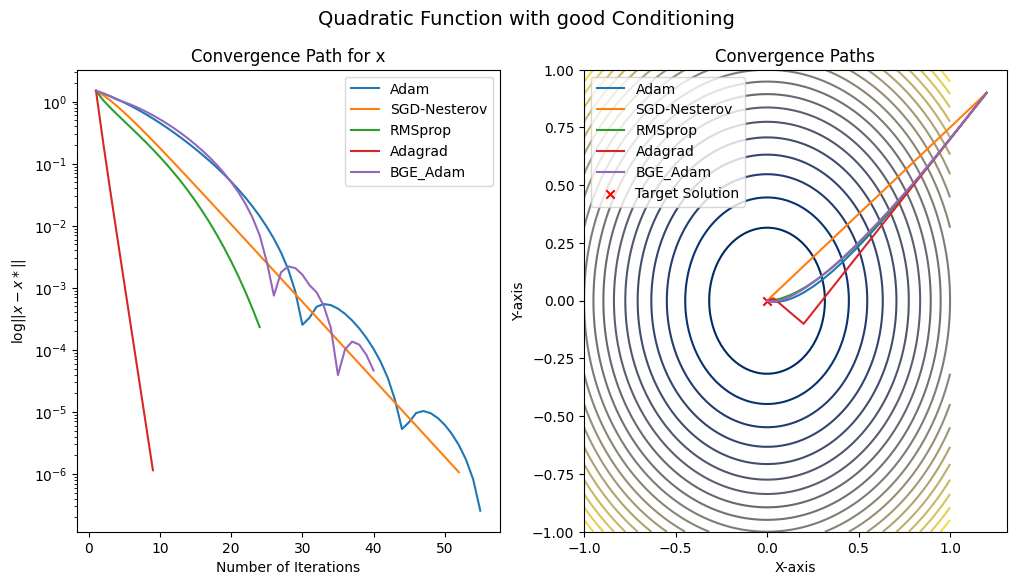

In [ ]:
# Define the target solution for optimization
x_star = torch.tensor([0, 0])

# Define the optimizers and their configurations
optimizers_config = {
    "Adam": (AdamOptimizer, {"lr": 1e-1, "beta1": 0.55, "beta2": 0.999}),
    "SGD-Nesterov": (optim.SGD, {
        "lr": 1e-1, "nesterov": True, "momentum": 0.5, "dampening": 0
    }),
    "RMSprop": (optim.RMSprop, {"lr": 1e-1, "alpha": 0.9}),
    "Adagrad": (optim.Adagrad, {"lr": 1e-0, "lr_decay": 0.}),
    "BGE_Adam": (BGE_Adam, {"lr": 0.1})
}

# Run optimization with multiple optimizers
sol_quad1, values = optimize_with_multiple_optimizers(
    x_init=[1.2, 0.9],
    loss_fn=quadratic_good,
    loss_grad=quadratic_good_grad,
    optimizers_config=optimizers_config,
    max_iter=1000,
    tol_grad=1e-6
)

# Plot convergence paths for different algorithms within a box
# Adjust title as needed
title = "Quadratic Function with good Conditioning" # "Quadratic Function with Good Conditioning"
plot_multiple_convergence_paths(
    sol_quad1, quadratic_good, x_star, box_scale=1, title=title
)


### Quadratic Function (bad conditioning)

In [ ]:
# # Run optimization with different hyperparameter configurations for quadratic_bad function
# sol_quad2, val_quad2 = optimize_workflow(
#     optimizers, param_grids, x_init,
#     loss_fn=quadratic_bad, loss_grad=quadratic_bad_grad
# )


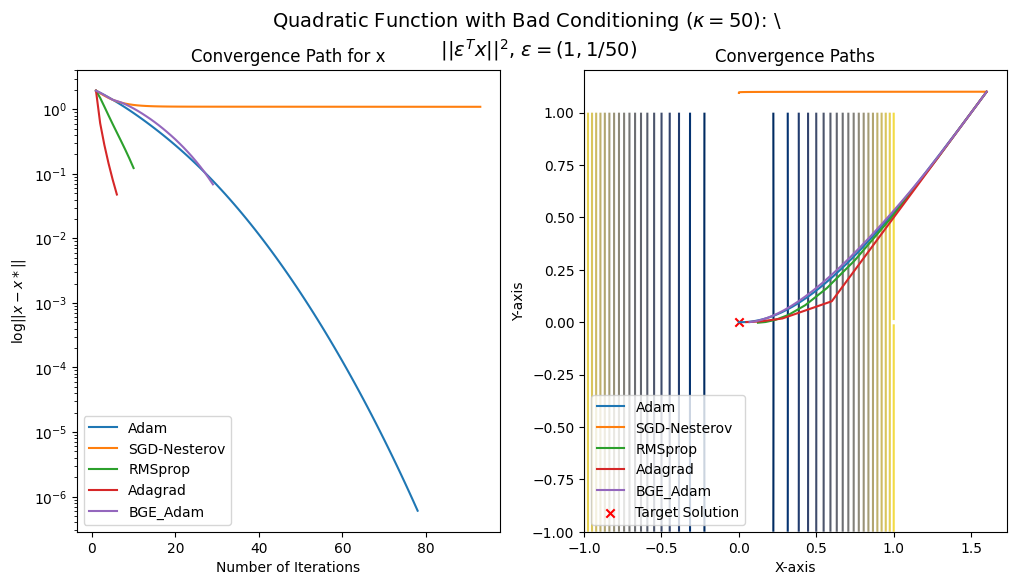

In [ ]:
# Define the optimizers and their configurations for quadratic_bad function
optimizers_config = {
    "Adam": (AdamOptimizer, {"lr": 1e-1, "beta1": 0.4, "beta2": 0.99999}),
    "SGD-Nesterov": (optim.SGD, {"lr": 1e-1, "nesterov": True, "momentum": 0.3, "dampening": 0}),
    "RMSprop": (optim.RMSprop, {"lr": 1e-1, "momentum": 0.3, "alpha": 0.9}),
    "Adagrad": (optim.Adagrad, {"lr": 1e-0, "lr_decay": 0.1}),
    "BGE_Adam": (BGE_Adam, {"lr": 0.1})
}

# Run optimization with multiple optimizers for quadratic_bad function
sol_quad2, values = optimize_with_multiple_optimizers(
    x_init=[1.6, 1.1],
    loss_fn=quadratic_bad,
    loss_grad=quadratic_bad_grad,
    optimizers_config=optimizers_config,
    max_iter=1000,
    tol_grad=1e-6
)

# Plot convergence paths for different algorithms within a box
# Adjust title as needed
title = rf"Quadratic Function with Bad Conditioning ($\kappa = 50$): \
    $|| \epsilon^T x ||^2$, $\epsilon = (1, 1/50)$"
plot_multiple_convergence_paths(sol_quad2, quadratic_bad, x_star, box_scale=1, title=title)

### Non-Convex Gaussian Kernel

In [ ]:
# sol_gauss, val_gauss = optimize_worklow(
#     optimizers, param_grids, x_init,
#     loss_fn=gauss, loss_grad=gauss_grad
# )

x_init = [0.4, 0.7]
| Optimizer       | Optimizer Class  | Hyperparameters                                   |
|-----------------|------------------|---------------------------------------------------|
| Adam            | AdamOptimizer    | {"lr": 1e-1, "beta1": 0.3, "beta2": 0.999999}    |
| SGD-Nesterov    | optim.SGD         | {"lr": 1e-0, "nesterov": True, "momentum": 0.5, "dampening": 0} |
| RMSprop         | optim.RMSprop     | {"lr": 1e-1, "alpha": 0.95}                       |
| Adagrad         | optim.Adagrad     | {"lr": 1e-1, "lr_decay": 0.0}                     |


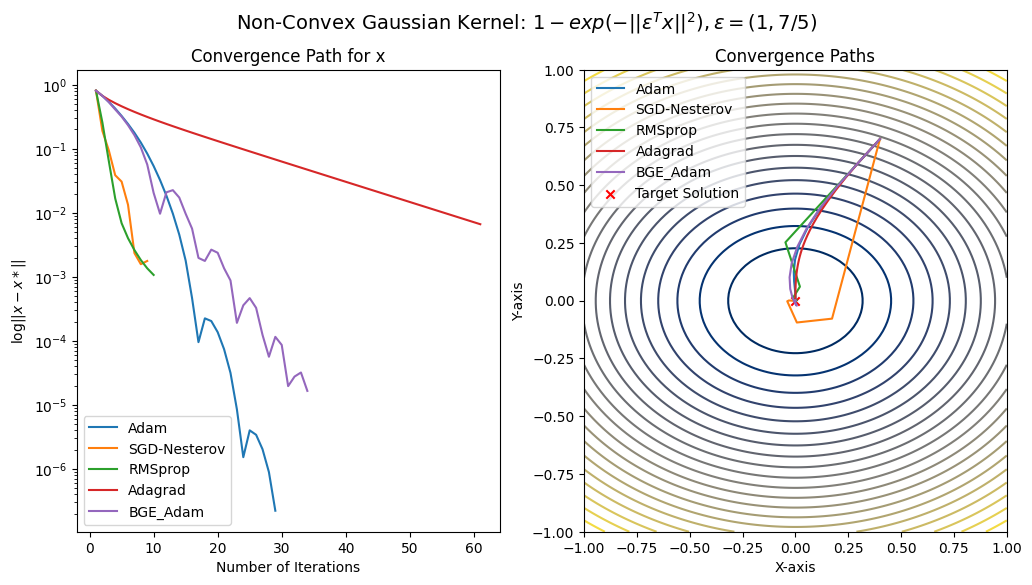

In [ ]:
# Define the optimizers and their configurations for gauss function
optimizers_config_gauss = {
    "Adam": (AdamOptimizer, {
        "lr": 1e-1, "beta1": 0.3, "beta2": 0.999999
    }),
    "SGD-Nesterov": (optim.SGD, {
        "lr": 1e-0, "nesterov": True, "momentum": 0.5, "dampening": 0
    }),
    "RMSprop": (optim.RMSprop, {"lr": 1e-1, "alpha": 0.95}),
    "Adagrad": (optim.Adagrad, {"lr": 1e-1, "lr_decay": 0.}),
    "BGE_Adam": (BGE_Adam, {"lr": 0.1})
}

# Run optimization with multiple optimizers for gauss function
sol_gauss, _ = optimize_with_multiple_optimizers(
    x_init=[0.4, 0.7],
    loss_fn=gauss,
    loss_grad=gauss_grad,
    optimizers_config=optimizers_config_gauss,
    max_iter=1000,
    tol_grad=1e-6
)

# Plot convergence paths for different algorithms within a box
# Adjust title as needed
title_gauss = (
    "Non-Convex Gaussian Kernel: $1 - exp(-|| \epsilon^T x ||^2), \epsilon = (1, 7/5)$"
)
plot_multiple_convergence_paths(sol_gauss, gauss, x_star, box_scale=1, title=title_gauss)


### Rosenbrock Function (flat region)

In [ ]:
# sol_rosen, val_rosen = optimize_worklow(
#     optimizers, param_grids, x_init=[1.6, 1.1],
#     loss_fn=rosenbrock, loss_grad=rosenbrock_grad
# )

x_init = [1.6, 1.1] ("above" the global solution to increase convergence likelihood)
| Optimizer       | Optimizer Class  | Hyperparameters                                   |
|-----------------|------------------|---------------------------------------------------|
| Adam            | AdamOptimizer    | {"lr": 1e-1, "beta1": 0.95, "beta2": 0.994}      |
| SGD-Nesterov    | optim.SGD         | {"lr": 1e-4, "nesterov": True, "momentum": 0.9, "dampening": 0} |
| RMSprop         | optim.RMSprop     | {"lr": 2e-3, "momentum": 0.9, "alpha": 0.99}      |
| Adagrad         | optim.Adagrad     | {"lr": 1e-2, "lr_decay": 0.0001}                  |

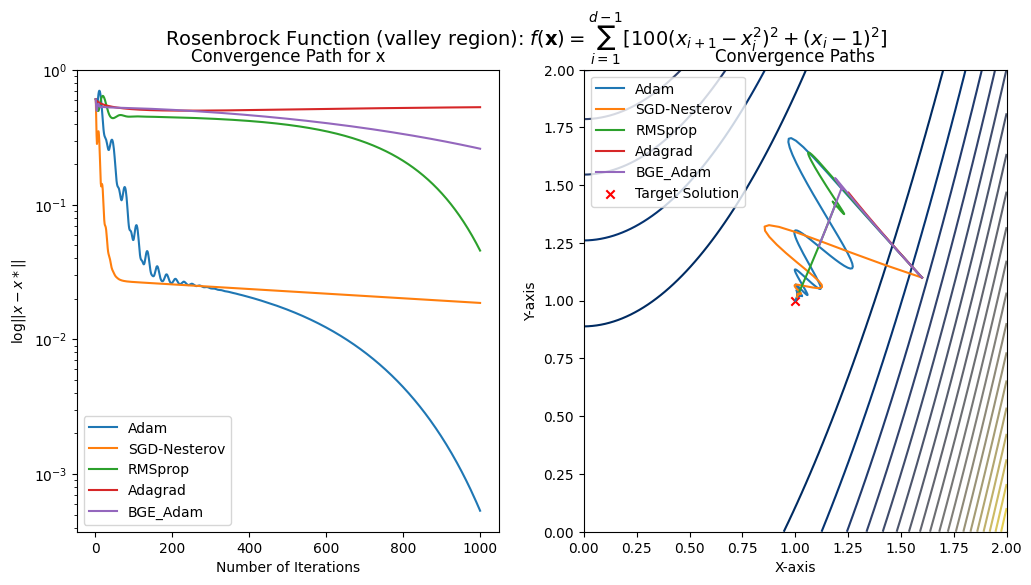

In [ ]:
# Define the optimizers and their configurations for rosenbrock function
optimizers_config_rosen = {
    "Adam": (AdamOptimizer, {"lr": 1e-1, "beta1": 0.95, "beta2": 0.994}),
    "SGD-Nesterov": (optim.SGD, {
        "lr": 1e-4, "nesterov": True, "momentum": 0.9, "dampening": 0
    }),
    "RMSprop": (optim.RMSprop, {"lr": 2e-3, "momentum": 0.9, "alpha": 0.99}),
    "Adagrad": (optim.Adagrad, {"lr": 1e-2, "lr_decay": 0.0001}),
    "BGE_Adam": (BGE_Adam, {"lr": 1e-1})
}

# Run optimization with multiple optimizers for rosenbrock function
sol_rosen, _ = optimize_with_multiple_optimizers(
    x_init=[1.6, 1.1],
    loss_fn=rosenbrock,
    loss_grad=rosenbrock_grad,
    optimizers_config=optimizers_config_rosen,
    max_iter=1000,
    tol_grad=1e-6
)

# Plot convergence paths for different algorithms within a box
# Adjust title as needed
title_rosen = "Rosenbrock Function (valley region): $f(\mathbf{x}) = \\sum_{i=1}^{d-1} [100(x_{i+1} - x_i^2)^2 + (x_i - 1)^2]$"
plot_multiple_convergence_paths(sol_rosen, rosenbrock, x_star=torch.tensor([1, 1]), box_scale=1, title=title_rosen)


### Ackley (local minima)

In [ ]:
# sol_ackley, val_ackley = optimize_worklow(
#     optimizers, param_grids, x_init,
#     loss_fn=ackley, loss_grad=ackley_grad
# )

x_init = [0.37, 0.95] (random guess)
| Optimizer       | Optimizer Class  | Hyperparameters                                   |
|-----------------|------------------|---------------------------------------------------|
| Adam            | AdamOptimizer    | {"lr": 1e-1, "beta1": 0.5, "beta2": 0.999}       |
| SGD-Nesterov    | optim.SGD         | {"lr": 1e-2, "nesterov": True, "momentum": 0.9, "dampening": 0} |
| RMSprop         | optim.RMSprop     | {"lr": 1e-2, "momentum": 0.3, "alpha": 0.9}      |
| Adagrad         | optim.Adagrad     | {"lr": 1e-0, "lr_decay": 1.17}                   |


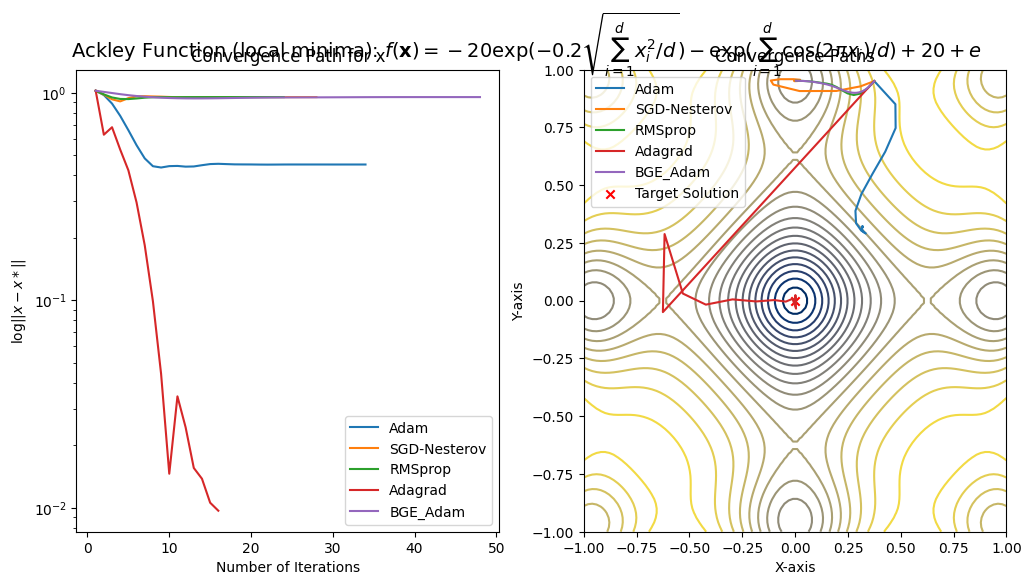

In [ ]:
# Define the optimizers and their configurations for ackley function
optimizers_config_ackley = {
    "Adam": (AdamOptimizer, {"lr": 1e-1, "beta1": 0.5, "beta2": 0.999}),
    "SGD-Nesterov": (optim.SGD, {"lr": 1e-2, "nesterov": True, "momentum": 0.9, "dampening": 0}),
    "RMSprop": (optim.RMSprop, {"lr": 1e-2, "momentum": 0.3, "alpha": 0.9}),
    "Adagrad": (optim.Adagrad, {"lr": 1e-0, "lr_decay": 1.17}),
    "BGE_Adam": (BGE_Adam, {"lr": 0.01})
}

# Run optimization with multiple optimizers for ackley function
sol_ackley, _ = optimize_with_multiple_optimizers(
    x_init=x_init,
    loss_fn=ackley,
    loss_grad=ackley_grad,
    optimizers_config=optimizers_config_ackley,
    max_iter=1000,
    tol_grad=1e-6
)

# Plot convergence paths for different algorithms within a box
# Adjust title as needed
title_ackley = "Ackley Function (local minima): $f(\mathbf{x}) = -20 \exp(-0.2 \sqrt{\\sum_{i=1}^{d} x_i^2/d}) - \exp(\\sum_{i=1}^{d} \cos(2\pi x_i)/d) + 20 + e$"
plot_multiple_convergence_paths(sol_ackley, ackley, x_star=torch.tensor([0, 0]), box_scale=1, title=title_ackley)
